In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, auc, roc_auc_score, roc_curve, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, DotProduct
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn import svm
from sklearn.cluster import KMeans

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt


In [4]:
np.random.seed(1000)

In [5]:
train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

In [6]:
data = np.loadtxt("company_log.csv",delimiter=',')

In [7]:
shufdata = np.random.permutation(data) #(Shuffle 1st time)
x_data = shufdata[:,1:-1]
y_data = shufdata[:,-1]


In [8]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, \
                                                    test_size=1 - train_ratio, stratify=y_data) #Shuffle (2nd time) and stratified to take care of class imbalance
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, \
                                                test_size=test_ratio/(test_ratio + validation_ratio),stratify=y_test) #Sub-Shuffle (3rd time) and stratified to take care of class imbalance


In [9]:
scaler = preprocessing.StandardScaler().fit(x_train)
x_train_sc = scaler.transform(x_train)
x_val_sc = scaler.transform(x_val)
x_test_sc = scaler.transform(x_test)

In [10]:
logreg = LogisticRegression().fit(x_train_sc, y_train)


In [11]:
y_pred = logreg.predict(x_test_sc)
score = logreg.score(x_test_sc, y_test)
print('Accuracy of logistic regression classifier on val set: {:.6f}'.format(score))


Accuracy of logistic regression classifier on val set: 0.958333


In [12]:
cm = confusion_matrix(y_test, y_pred)
print(cm)
print(classification_report(y_test, y_pred))


[[80  0]
 [ 4 12]]
              precision    recall  f1-score   support

         0.0       0.95      1.00      0.98        80
         1.0       1.00      0.75      0.86        16

    accuracy                           0.96        96
   macro avg       0.98      0.88      0.92        96
weighted avg       0.96      0.96      0.96        96



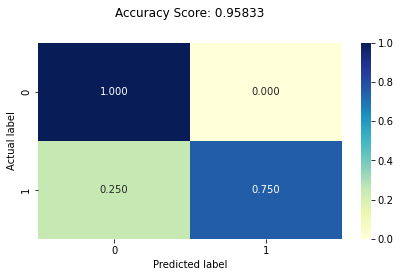

In [13]:
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure()
sns.heatmap(cmn, annot=True, fmt='.3f', cmap="YlGnBu");
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = ('Accuracy Score: %.5f' %score)
plt.tight_layout()
plt.title(all_sample_title, y=1.1);
plt.tight_layout()
plt.savefig('sav_images/confusion_matrix.svg',transparent=True)
plt.show()


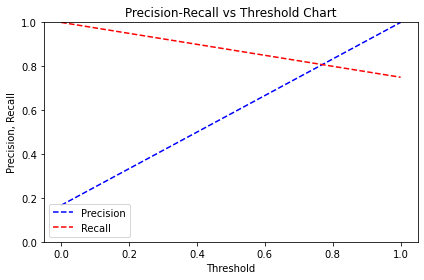

In [14]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall, precision)
plt.figure()
plt.title("Precision-Recall vs Threshold Chart")
plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])
plt.tight_layout()
plt.savefig('sav_images/pr-threshold.svg',transparent=True)
plt.show()

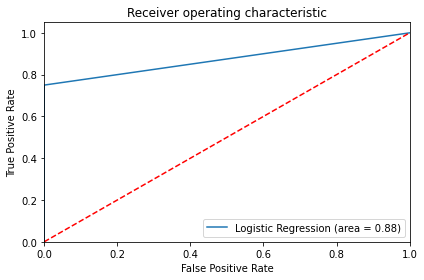

In [15]:
logit_roc_auc = roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig('sav_images/roc_curve.svg',transparent=True)
plt.show()


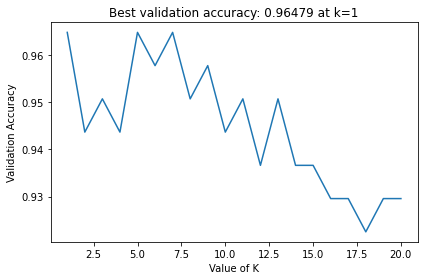

In [16]:
k_range = range(1,21)
score_knn = np.zeros(max(k_range))
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train_sc,y_train)
    y_pred_knn = knn.predict(x_val_sc)
    score_knn[k-1]=(accuracy_score(y_val, y_pred_knn))
# print('Accuracy of KNN classifier on val set: {:.5f}'.format(max(score_knn)))
mxknn = max(score_knn)
indknn = np.argmax(score_knn)+1
plt.figure()
plt.plot(k_range,score_knn)
plt.xlabel("Value of K")
plt.ylabel("Validation Accuracy")
plt.title('Best validation accuracy: {:.5f} at k={}'.format(mxknn,indknn))
plt.tight_layout()
plt.savefig('sav_images/k_val.svg',transparent=True)
plt.show()

In [17]:
knn = KNeighborsClassifier(n_neighbors=indknn)
knn.fit(x_train_sc,y_train)
y_pred_knn = knn.predict(x_test_sc)
score_knn_test=(accuracy_score(y_test, y_pred_knn))
print('Accuracy of KNN classifier on test set: {:.5f}'.format(score_knn_test))

Accuracy of KNN classifier on test set: 0.91667


In [18]:
kernel1 = 1.0 * RBF(1.0)
# kernel2 = 1.0 * DotProduct(sigma_0=1.0)**2
gpc = GaussianProcessClassifier(kernel=kernel1).fit(x_train_sc,y_train)
y_pred_gpc = gpc.predict(x_test_sc)
score_gpc = gpc.score(x_test_sc,y_test)
print('Accuracy of GP classifier on test set: {:.5f}'.format(score_gpc))


Accuracy of GP classifier on test set: 0.95833


In [19]:
gnb = GaussianNB().fit(x_train_sc,y_train)
y_pred_gnb = gnb.predict(x_test_sc)
score_gnb = gnb.score(x_test_sc,y_test)
print('Accuracy of GNB classifier on test set: {:.5f}'.format(score_gnb))

Accuracy of GNB classifier on test set: 0.91667


In [20]:
mlp = MLPClassifier(hidden_layer_sizes=(10,10)).fit(x_train_sc,y_train)
y_pred_mlp = mlp.predict(x_test_sc)
score_mlp = mlp.score(x_test_sc,y_test)
print('Accuracy of MLP classifier on test set: {:.5f}'.format(score_mlp))

Accuracy of MLP classifier on test set: 0.96875


c:\Users\ramas\anaconda3\envs\machine_learning\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
